# Dinamic Light Scattering
D. Pomogaev and E. Imaykina

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # I use seborn because I love seaborn
from scipy.optimize import curve_fit

In [3]:
# Adding gold data
data = pd.DataFrame([
    {'theta':  20, 'I, cps': 805e3, 'dI, cps': 2e4, 'tc, ms': 3.570, 'dtc, s': 1.118},
    {'theta':  30, 'I, cps': 585e3, 'dI, cps': 2e4, 'tc, ms': 2.056, 'dtc, s': 0.572},
    {'theta':  40, 'I, cps': 478e3, 'dI, cps': 5e3, 'tc, ms': 1.189, 'dtc, s': 0.805},
    {'theta':  50, 'I, cps': 410e3, 'dI, cps': 6e3, 'tc, ms': 0.619, 'dtc, s': 0.158},
    {'theta':  60, 'I, cps': 342e3, 'dI, cps': 6e3, 'tc, ms': 0.483, 'dtc, s': 0.132},
    {'theta':  70, 'I, cps': 345e3, 'dI, cps': 6e3, 'tc, ms': 0.356, 'dtc, s': 0.109},
    {'theta':  80, 'I, cps': 333e3, 'dI, cps': 4e3, 'tc, ms': 0.288, 'dtc, s': 0.160},
    {'theta':  90, 'I, cps': 323e3, 'dI, cps': 9e3, 'tc, ms': 0.228, 'dtc, s': 0.063},
    {'theta': 100, 'I, cps': 323e3, 'dI, cps': 9e3, 'tc, ms': 0.205, 'dtc, s': 0.070},
    {'theta': 120, 'I, cps': 368e3, 'dI, cps': 3e3, 'tc, ms': 0.167, 'dtc, s': 0.069},
    {'theta': 130, 'I, cps': 387e3, 'dI, cps': 5e3, 'tc, ms': 0.143, 'dtc, s': 0.075},
    {'theta': 140, 'I, cps': 462e3, 'dI, cps': 1e4, 'tc, ms': 0.121, 'dtc, s': 0.048},
])
data['sample'] = 'gold'

# Adding sulfur data
data2 = pd.DataFrame([
    [ 20, 2.8e6, 150e3, 21.52, 4.951],
    [ 30, 2.3e6, 100e3, 9.215, 2.626],
    [ 40, 205e4, 100e3, 5.027, 1.664],
    [ 50, 172e4, 3.0e4, 3.997, 0.574],
    [ 60, 1.5e6, 3.0e4, 2.998, 1.026],
    [ 70, 127e4, 2.0e4, 2.190, 0.478],
    [ 80, 113e4, 2.0e4, 1.698, 0.358],
    [ 90, 105e4, 1.5e4, 1.348, 0.269],
    [100, 940e3, 1.0e4, 1.003, 0.299],
    [110, 940e3, 2.0e4, 0.991, 0.236],
    [120, 880e3, 1.0e4, 0.780, 0.067],
    [130, 935e3, 1.5e4, 0.652, 0.069],
    [140, 103e4, 1.5e4, 0.554, 0.047]
], columns = ('theta', 'I, cps', 'dI, cps', 'tc, ms', 'dtc, s'))
data2['sample'] = 'sulfur'

# Merge data from two df's into one
data = pd.concat((data, data2))
del data2
data.head()

,theta,"I, cps","dI, cps","tc, ms","dtc, s",sample
0,20,805000.0,20000.0,3.570,1.118,gold
1,30,585000.0,20000.0,2.056,0.572,gold
2,40,478000.0,5000.0,1.189,0.805,gold
3,50,410000.0,6000.0,0.619,0.158,gold
4,60,342000.0,6000.0,0.483,0.132,gold


In [32]:
# Add normilized Intensity with error
for mat in ('gold', 'sulfur'):
    a = data[data['sample'] == mat]
    data['I_norm'] = a['I, cps']/a.loc[a['theta'] == 90, 'I, cps'].values[0]
    data['dI_norm'] = a['dI, cps']/a.loc[a['theta'] == 90, 'I, cps'].values[0]

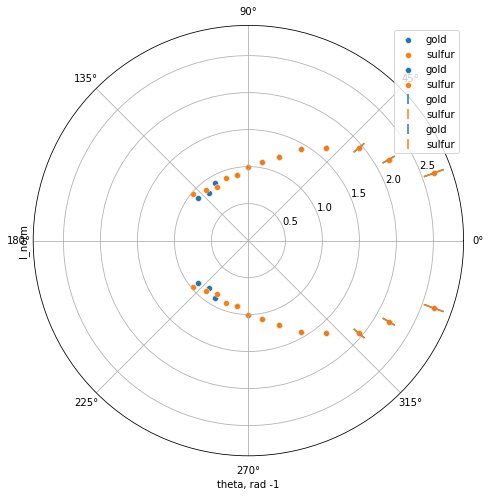

In [61]:
# Build indicatrice of refraction in polar coordinates
data['theta, rad'] = data['theta']/180 * np.pi
data['theta, rad -1'] = data['theta, rad'] * -1
data['I_norm_sined'] = data['I_norm'] * np.sin(data['theta, rad'])
data['dI_norm_sined'] = data['dI_norm'] * np.sin(data['theta, rad'])

g = sns.FacetGrid(data, hue="sample",
                  subplot_kws=dict(projection='polar'), height=7,
                  sharex=False, sharey=False, despine=False)

y_str = 'I_norm'
dy_str = 'dI_norm'
g.map(sns.scatterplot, 'theta, rad', y_str)
g.map(sns.scatterplot, 'theta, rad -1', y_str, label=None)
g.map(plt.errorbar, 'theta, rad', y_str, dy_str, linestyle='', label=None)
g.map(plt.errorbar, 'theta, rad -1', y_str, dy_str, linestyle='', label=None)

# plt.legend() TODO: understand how to make a nice looking legend

# TODO: ADD TABLE OF CALCULATED VALUES (export as LaTeX)
# Table columns: theta, sin theta, I_norm, I_norm_sined, d(I_norm_sined)

# TODO: label axes and add title

1.8819987749289456e-08
9.430071523662418e-08


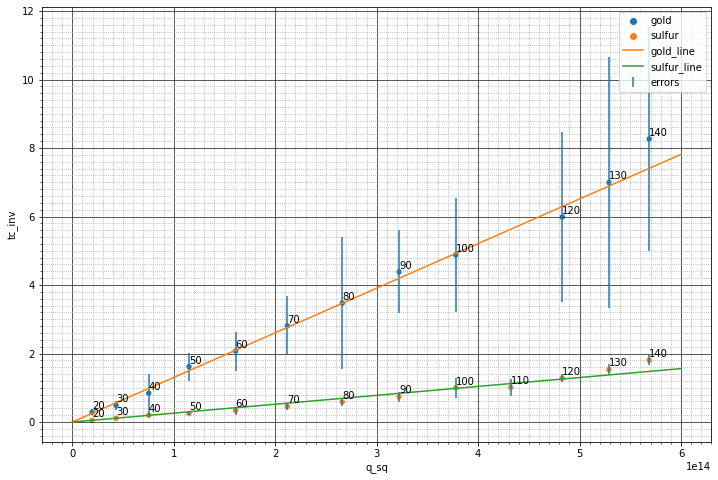

In [59]:
lmb = 658.6e-9 # LASER wavelength
eta = 8.9e-4 # Pa*s - water viscousity

data['tc_inv'] = 1/data['tc, ms']
data['dtc_inv'] = data['dtc, s']/(data['tc, ms'])**2
data['I_square'] = data['I_norm']**2
data['q_sq'] = (4*np.pi*1.33/lmb*np.sin(data['theta, rad']/2))**2

f = lambda x, k: k*x

data_g = data[data['sample'] == 'gold']
data_s = data[data['sample'] == 'sulfur']
popt1, pcov1 = curve_fit(f, data_g['q_sq'], data_g['tc_inv'], sigma=data_g['dtc_inv'])
popt2, pcov2 = curve_fit(f, data_s['q_sq'], data_s['tc_inv'], sigma=data_s['dtc_inv'])

xs = np.linspace(0, 6e14)
ys1 = f(xs, *popt1)
ys2 = f(xs, *popt2)

plt.figure(figsize=(12, 8))
ax = plt.axes()
# Build points with error bars
sns.scatterplot(data = data, x='q_sq', y='tc_inv', hue='sample')
plt.errorbar(data=data, x = 'q_sq', y='tc_inv', yerr='dtc_inv', linestyle='', label='errors')

# Build fitting line
sns.lineplot(x=xs, y=ys1, label='gold_line')
sns.lineplot(x=xs, y=ys2, label='sulfur_line')

# Add angle labels
for i, row in data.iterrows():
    plt.text(x=row['q_sq']+0.02, y=row['tc_inv']+0.1, s=row['theta'])

# Add grid (very nice looking one :D)
from matplotlib.ticker import MultipleLocator
plt.grid(which='major', color='#323232', linestyle='-')
plt.grid(which='minor', color='#a4a4a4', linestyle=':')
mlx = MultipleLocator(1e13)
ax.xaxis.set_minor_locator(mlx) 
mly = MultipleLocator(0.2)
ax.yaxis.set_minor_locator(mly)

R = lambda D: 1.38e-23*298/(6*3.1415*eta*D)

# TODO: display calculated data as a pink box™
props = dict(boxstyle='round', facecolor='#ef21c8', alpha=0.8)
# text = 'Размер частиц:\nзолота: {g}±{dg}\nсеры: {s}±{ds}'.format()
# plt.text(0.10, 0.88, text, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)
print(R(popt1[0]*1e3)) # DELETE after making a pink pox™
print(R(popt2[0]*1e3)) # DELETE after making a pink pox™

# TODO: Add table of plot data (export as LaTeX)
# Table columns: theta, q_sq, t, dt, 1/t, d(1/t)

# TODO: label axes and add title
# TODO: make uniform colors for lines, errors and points